In [7]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import torch
from gplib import GenPhotonLib

with h5py.File('data/lightLUT_Mod0.h5', 'r') as f:
    d = f['arr'][:]
    
gplib = GenPhotonLib.load("../photonlib/bin/plib_2x2_module0.h5")

[PhotonLib] loading ../photonlib/bin/plib_2x2_module0.h5
[PhotonLib] file loaded


In [8]:
# X: x voxels
# Y: y voxels
# Z: z voxels
# C: channels
# T: time steps

"""Check shapes of vis and time_dist the same"""
X, Y, Z, C = d["vis"].shape
X, Y, Z, C, T = d["time_dist"].shape
assert d["vis"].shape == d["time_dist"].shape[:4]

"""Reduce number of channels to 48"""
C = 48
input = np.empty((X, Y, Z, C), dtype=d.dtype)
input["vis"] = d["vis"][..., :C]
# normalize time_dist to 1
input["time_dist"] = d["time_dist"][..., :C, :]
input['time_dist'] = np.nan_to_num(input["time_dist"] / np.sum(input["time_dist"], axis=-1, keepdims=True))
input["t0"] = d["t0"][..., :C]

values = torch.cat(
    [
        torch.tensor(d["vis"]),
        torch.tensor(d["time_dist"]).reshape(X, Y, Z, -1),
    ],
    dim=-1,
).reshape(-1, C * T + C)  # (Z*Y*X, C + C*T)

/tmp/ipykernel_1275778/449727369.py:18: RuntimeWarning: invalid value encountered in true_divide
  input['time_dist'] = np.nan_to_num(input["time_dist"] / np.sum(input["time_dist"], axis=-1, keepdims=True))


In [9]:
GenPhotonLib.save("ptlib_2x2_module0.h5", values, gplib.meta)

[PhotonLib] saving to ptlib_2x2_module0.h5
[PhotonLib] file saved


: 

In [3]:
t_ravel = input["time_dist"].ravel()

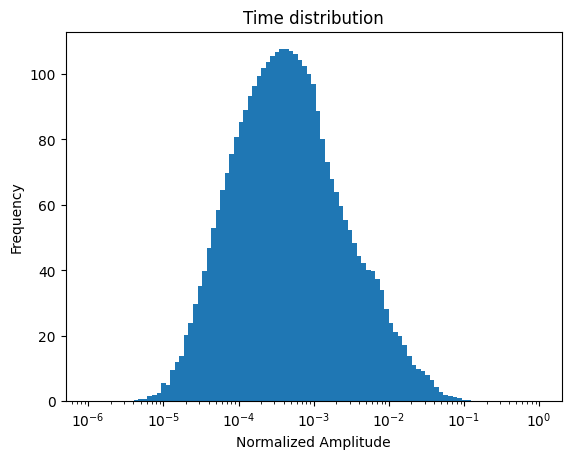

In [235]:
plt.hist(t_ravel, bins=np.logspace(-6, 0, 100), density=True)
plt.xscale('log')
plt.title("Time distribution")
plt.xlabel("Normalized Amplitude")
plt.ylabel("Frequency")
plt.show()

Dataset shape: (64, 128, 32, 48, 100)


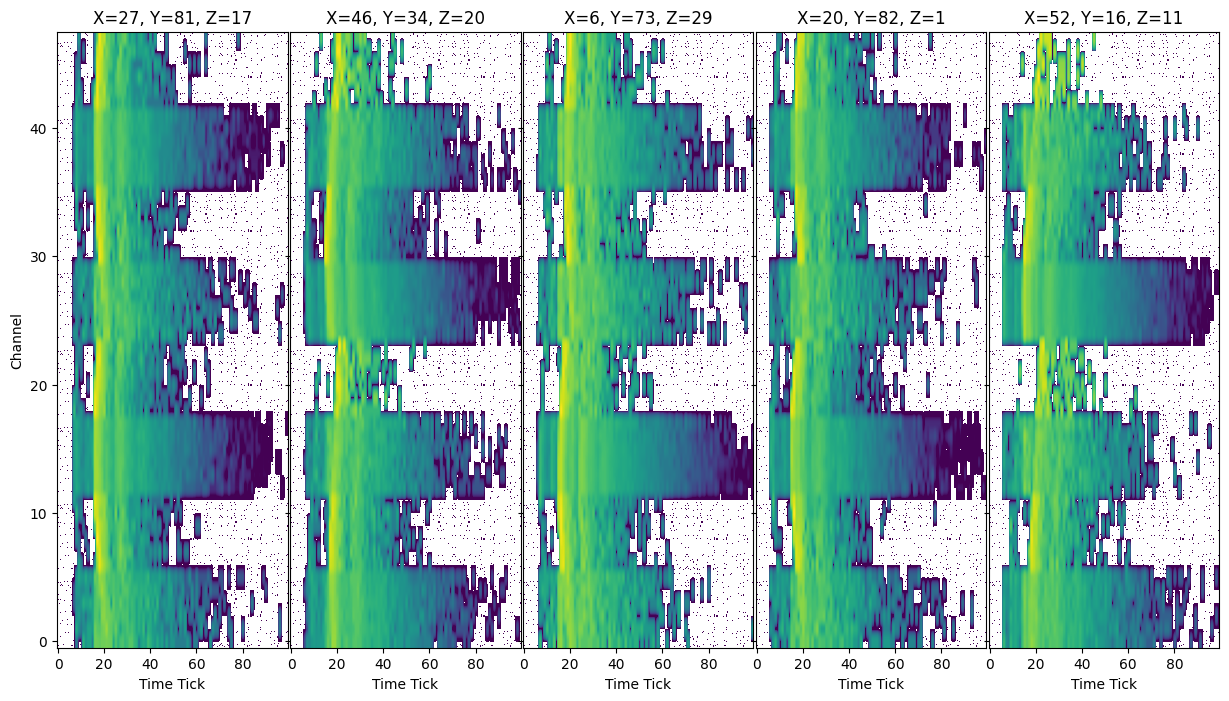

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

data = d["time_dist"]

X, Y, Z, C, T = data.shape
print(f"Dataset shape: {data.shape}")

# Choose the middle slice for visualization

fig, ax = plt.subplots(1, 5, figsize=(15, 8), sharey=True)
# remove space between subplots
plt.subplots_adjust(wspace=0.01)

for i in range(5):
    currax = ax[i]

    X_slice = np.random.randint(X)
    Y_slice = np.random.randint(Y)
    Z_slice = np.random.randint(Z)

    currax.imshow(
        data[X_slice, Y_slice, Z_slice, :, :], cmap="viridis", norm=LogNorm(),
        origin="lower", aspect="auto"
    )
    currax.set_title(f"X={X_slice}, Y={Y_slice}, Z={Z_slice}")
    currax.set_xlabel("Time Tick")
    
ax[0].set_ylabel("Channel")
plt.show()

Dataset shape: (64, 128, 32, 48)


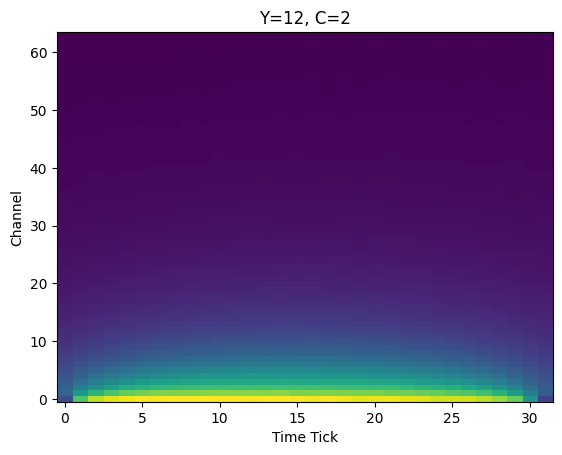

In [52]:
data = d["vis"]

X, Y, Z, C = data.shape
print(f"Dataset shape: {data.shape}")


# X_slice = np.random.randint(X)
# Y_slice = np.random.randint(Y)
# Z_slice = np.random.randint(Z)
Y_slice = int(Y*0.1)
channel = np.random.randint(C)

plt.imshow(
    data[:, Y_slice, :, channel],
    cmap="viridis",
    # norm=LogNorm(),
    origin="lower",
    aspect="auto",
)
plt.title(f"Y={Y_slice}, C={channel}")
plt.xlabel("Time Tick")
plt.ylabel("Channel")
plt.show()

In [6]:
import torch

# (X, Y, Z, C, T) -> (Z*Y*X, C + C*T)


In [7]:
input_tensor = torch.tensor(d['vis']).permute(2,1,0,3)

# Verify the ordering
assert torch.allclose(values2[0, :48], input_tensor[0, 0, 0])
assert torch.allclose(values2[1, :48], input_tensor[1, 0, 0])
assert torch.allclose(values2[Z + 1, :48], input_tensor[1, 1, 0])

In [162]:
output = values.permute(2, 1, 0, 3).reshape(-1, C)

In [165]:
torch.allclose(
    output[1, :48],
    torch.tensor(d["vis"]).permute(2,1,0,3)[0, 0, 0, :].reshape(-1),
)

False

In [130]:
d["vis"].shape

(64, 128, 32, 48)

In [129]:
values.reshape(X * Y * Z, -1)[1, :48]

tensor([1.0568e-03, 1.0568e-03, 6.7392e-05, 6.7392e-05, 2.7144e-05, 2.7144e-05,
        1.6380e-06, 1.6380e-06, 1.2090e-06, 1.1700e-06, 1.0140e-06, 1.4040e-06,
        3.0810e-06, 3.0810e-06, 2.3790e-06, 2.3790e-06, 1.4430e-06, 1.4430e-06,
        3.9000e-08, 1.5600e-07, 1.9500e-07, 1.1700e-07, 2.3400e-07, 7.8000e-08,
        2.3907e-05, 2.3907e-05, 2.5857e-05, 2.5857e-05, 2.0982e-05, 2.0982e-05,
        2.4180e-06, 2.5350e-06, 2.7690e-06, 2.3400e-06, 2.7690e-06, 2.4180e-06,
        1.1583e-05, 1.1583e-05, 6.5520e-06, 6.5520e-06, 4.8360e-06, 4.8360e-06,
        4.2900e-07, 5.8500e-07, 2.3400e-07, 3.1200e-07, 2.3400e-07, 3.5100e-07])

In [122]:
plib.meta.voxel_to_coord(0)

tensor([-14.6632, -62.6007, -30.5304])

In [124]:
plib.meta.voxel_to_coord(32)

tensor([-14.6632, -61.6148, -30.5304])

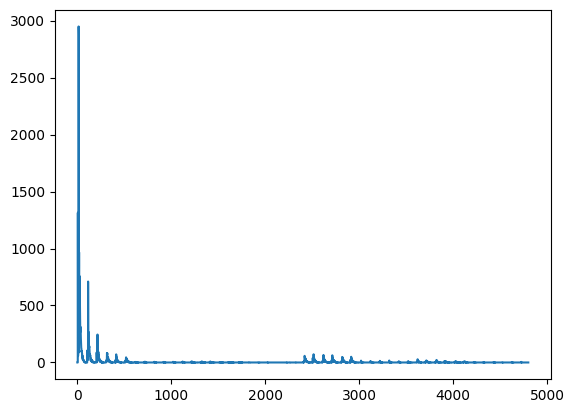

In [24]:
plt.plot(total[0,48:].ravel().numpy());

In [48]:
plib.meta.voxel_to_idx(32)

tensor([0, 1, 0])

In [47]:
plib.meta.shape

tensor([ 32, 128,  64])

/tmp/ipykernel_1245252/2088313406.py:8: RuntimeWarning: divide by zero encountered in log10
  counts = histogram1d(np.log10(reshaped[:,::C].numpy()), bins=100, range=(-9, 0))


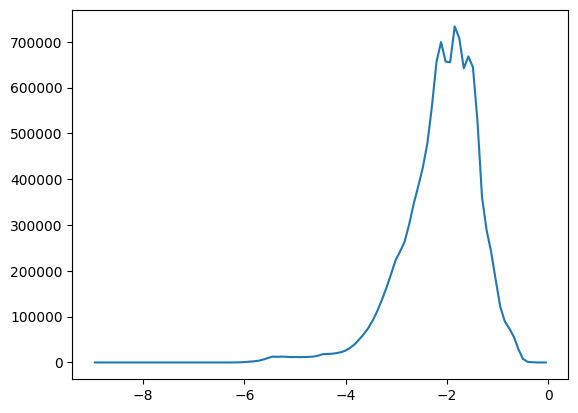

In [18]:
# Total shape: (X * Y * Z, C * T + C)
# 0th dim should be the number of samples
# 1st dim should be the number of features in order [vis0, ..., vis47, t^0_0, ..., t^0_99, t^1_0, ..., t^1_99, ..., t^47_99]


from fast_histogram import histogram1d
counts = histogram1d(np.log10(reshaped[:,::C].numpy()), bins=100, range=(-9, 0))
edges  = np.log10(np.logspace(-9, 0, 101))
centers = (edges[1:] + edges[:-1]) / 2
plt.plot(centers, counts)

In [28]:
from gplib import GenPhotonLib

plib = GenPhotonLib.load("../photonlib/bin/plib_2x2_module1.h5")
plib.meta.shape

[PhotonLib] loading ../photonlib/bin/plib_2x2_module1.h5
[PhotonLib] file loaded


tensor([ 32, 128,  64])

In [30]:
GenPhotonLib.save("plib_2x2_module123.h5", total, plib.meta)

[PhotonLib] saving to plib_2x2_module123.h5
[PhotonLib] file saved


In [53]:
import matplotlib.pyplot as plt

torch.Size([48, 100])

/tmp/ipykernel_1179209/2045058101.py:1: RuntimeWarning: divide by zero encountered in log10
  out = histogram1d(np.log10(total[:, :, 0].ravel()), bins=500, range=(-10, 0))


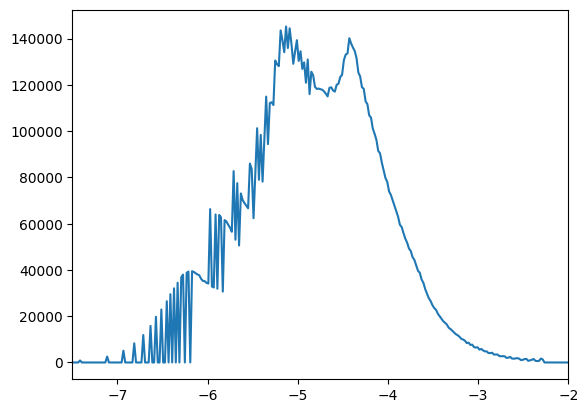

In [106]:
out = histogram1d(np.log10(total[:, :, 0].ravel()), bins=500, range=(-10, 0))
edges = np.linspace(-10, 0, 500)
plt.plot(edges, out)
plt.xlim(-7.5,-2)
# plt.yscale('log')


# plt.hist(total[:,:,0].ravel(), bins=np.logspace(-7, 0, 100))
# plt.xscale('log')
plt.show()

In [176]:
import torch

# Example usage
input_tensor = torch.tensor(d["vis"]).permute(2, 1, 0, 3)
output_tensor = input_tensor.permute(2, 1, 0, 3).reshape(-1, C)

print(f"Input shape: {input_tensor.shape}")
print(f"Output shape: {output_tensor.shape}")

# Verify the ordering
assert torch.allclose(output_tensor[0], input_tensor[0, 0, 0])
assert torch.allclose(output_tensor[1], input_tensor[1, 0, 0])
assert torch.allclose(output_tensor[Z + 1], input_tensor[1, 1, 0])

print("Reshaping successful and order verified!")

Input shape: torch.Size([32, 128, 64, 48])
Output shape: torch.Size([262144, 48])
Reshaping successful and order verified!


In [142]:
torch.allclose(input_tensor.permute(2,1,0,3),
               input_tensor.reshape(X,Y,Z,C))

False